In [4]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.2 MB/s eta 0:00:00


In [5]:
import keras_tuner as kt
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.mixed_precision import set_global_policy
from sklearn.model_selection import train_test_split

In [6]:
set_global_policy('mixed_float16')

In [7]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

In [9]:
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
X_valid = X_valid.astype('float32')

X_train = X_train/255.0
X_valid = X_valid/255.0
X_test = X_test/255.0

In [12]:
import tensorflow as tf
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_valid = tf.keras.utils.to_categorical(y_valid, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [13]:
# Define a hypermodel function
def build_resnet_model(hp):
    inputs = layers.Input(shape=(32, 32, 3))

    # Tunable number of filters in the initial layer
    x = layers.Conv2D(
        filters=hp.Choice("conv1_filters", [32, 64, 128]),
        kernel_size=(3, 3),
        padding="same",
        activation="relu"
    )(inputs)
    x = layers.BatchNormalization()(x)

    # First residual block
    for _ in range(hp.Int("residual_blocks_1", 1, 3)):  # Tunable number of blocks
        residual = x
        x = layers.Conv2D(
            filters=hp.Choice("block1_filters", [32, 64]),
            kernel_size=(3, 3),
            padding="same",
            activation="relu"
        )(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(
            filters=hp.Choice("block1_filters", [32, 64]),
            kernel_size=(3, 3),
            padding="same",
            activation=None
        )(x)
        x = layers.BatchNormalization()(x)

        if residual.shape[-1] != x.shape[-1]:  # Match the number of filters
            residual = layers.Conv2D(
                filters=x.shape[-1], kernel_size=(1, 1), padding="same"
            )(residual)

        x = layers.Add()([x, residual])
        x = layers.ReLU()(x)

    # Second residual block
    x = layers.Conv2D(
        filters=hp.Choice("block2_filters", [64, 128]),
        kernel_size=(3, 3),
        strides=(2, 2),
        padding="same",
        activation="relu"
    )(x)
    x = layers.BatchNormalization()(x)
    for _ in range(hp.Int("residual_blocks_2", 1, 3)):  # Tunable number of blocks
        residual = x
        x = layers.Conv2D(
            filters=hp.Choice("block2_filters", [64, 128]),
            kernel_size=(3, 3),
            padding="same",
            activation="relu"
        )(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(
            filters=hp.Choice("block2_filters", [64, 128]),
            kernel_size=(3, 3),
            padding="same",
            activation=None
        )(x)
        x = layers.BatchNormalization()(x)

        if residual.shape[-1] != x.shape[-1]:  # Match the number of filters
            residual = layers.Conv2D(
                filters=x.shape[-1], kernel_size=(1, 1), padding="same"
            )(residual)

        x = layers.Add()([x, residual])
        x = layers.ReLU()(x)

    # Global average pooling and output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(hp.Float("dropout_rate", 0.2, 0.5))(x)  # Tunable dropout rate
    outputs = layers.Dense(10, activation="softmax")(x)

    model = models.Model(inputs, outputs)

    # Compile the model with a tunable learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])
        ),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [14]:
tuner = kt.RandomSearch(
    build_resnet_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=1,
    directory="/content/drive/MyDrive/cifar10_models/resnet_tuning",
    project_name="cifar10_resnet",
)

In [15]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

In [16]:
tuner.search(
    X_train,
    y_train,
    epochs=10,
    validation_split=0.2,
    batch_size=64,
)

Trial 10 Complete [00h 03m 27s]
val_accuracy: 0.6946666836738586

Best val_accuracy So Far: 0.8151111006736755
Total elapsed time: 00h 42m 08s


In [17]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")

Best Hyperparameters: {'conv1_filters': 128, 'residual_blocks_1': 1, 'block1_filters': 32, 'block2_filters': 128, 'residual_blocks_2': 2, 'dropout_rate': 0.4834147841297928, 'learning_rate': 0.001}


In [18]:
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    X_train, y_train, epochs=50, validation_data=(X_valid, y_valid), batch_size=64, callbacks=[stop_early]
)

Epoch 1/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 35s 36ms/step - accuracy: 0.3542 - loss: 1.8249 - val_accuracy: 0.4938 - val_loss: 1.3982
Epoch 2/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.6050 - loss: 1.1113 - val_accuracy: 0.5952 - val_loss: 1.1314
Epoch 3/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.6868 - loss: 0.8944 - val_accuracy: 0.7056 - val_loss: 0.8214
Epoch 4/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.7395 - loss: 0.7502 - val_accuracy: 0.6584 - val_loss: 1.0392
Epoch 5/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.7842 - loss: 0.6334 - val_accuracy: 0.7626 - val_loss: 0.6959
Epoch 6/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.8110 - loss: 0.5619 - val_accuracy: 0.7988 - val_loss: 0.5900
Epoch 7/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.8371 - loss: 0.4798 - val_accuracy: 0.8086 - val_loss: 0.5589
Epoch 8/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.8552 - loss: 0.4345 - 

In [19]:
best_model.save('/content/drive/MyDrive/cifar10_models/cifar10_hyper-tuned.h5')

In [20]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict probabilities for the test set
y_pred = best_model.predict(X_test)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure y_true is in the correct shape (integer labels, not one-hot encoded)
y_true = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test.flatten()

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


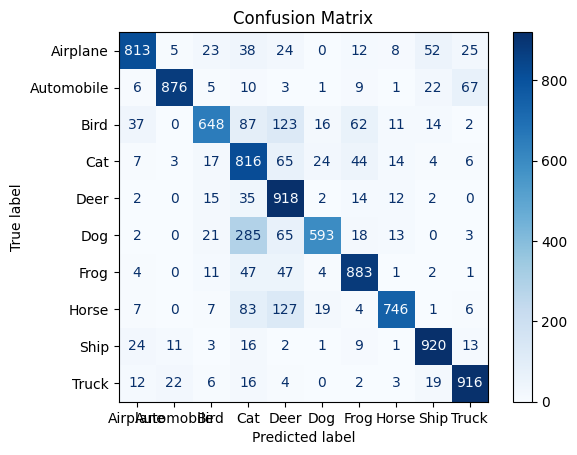

              precision    recall  f1-score   support

    Airplane       0.89      0.81      0.85      1000
  Automobile       0.96      0.88      0.91      1000
        Bird       0.86      0.65      0.74      1000
         Cat       0.57      0.82      0.67      1000
        Deer       0.67      0.92      0.77      1000
         Dog       0.90      0.59      0.71      1000
        Frog       0.84      0.88      0.86      1000
       Horse       0.92      0.75      0.82      1000
        Ship       0.89      0.92      0.90      1000
       Truck       0.88      0.92      0.90      1000

    accuracy                           0.81     10000
   macro avg       0.84      0.81      0.81     10000
weighted avg       0.84      0.81      0.81     10000



In [21]:
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Define class labels (modify these according to your dataset)
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=labels))